# 06 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

### 규제 선형 모델 개요

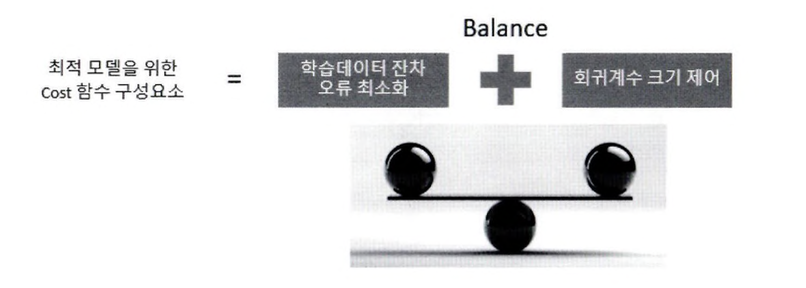

- 비용함수 목표 = Min(RSS(W) + alpha*||W||)

- 여기서 alpha는 학습 데이터 적합 정도와 회귀 계수 갑스이 크기 제어를 수행하는 튜닝 파라미터임.
- alpha=0인 경우 W가 커도 alpha*||W||가 0이 되어 비용 함수는 Min(RSS(W))
- alpha=inf인 경우 alpha*||W||도 무한대가 되므로 비용 함수는 W를 0에 가깝게 최소화해야 함

### 규제(Regularization)
- 비용 함수에 alpha 값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합 개선하는 방식
- 규제는 L2 방식과 L1 방식으로 구분됨
- L2 규제를 적용한 회귀를 '랏자 회귀'
- L1 규제를 적용한 회귀를 '라쏘 회귀'

### 릿지 회귀
- 사이킷런은 Rigde 클래스를 통해 릿지 회귀를 구현
- Ridge 클래스의 주요 생성 파라미터는 alpha, 이는 릿지 회귀의 alpha L2 규제 계수에 해당

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

data_url="http://lib.stat.cmu.edu/datasets/boston"
raw_df=pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data=np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target=raw_df.values[1::2, 2]

bostonDF=pd.DataFrame(data, columns=['CRIM','ZN','INDUS','CHAS', 'NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'])

bostonDF['PRICE']=target
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/t6/l14298n92xx0dtft2b1m3sqm0000gn/T/ipykernel_36650/239132503.py:12: SyntaxWarning: invalid escape sequence '\s'
  raw_df=pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10으로 설정해 릿지 회귀 수행.
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE Scores:', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE Scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE : 5.518


In [8]:
# 릿지에 사용될 alpha 파라미터의 값 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값 반복하며 alpha에 따른 평균 rmse를 구함.
for alpha in alphas:
    ridge = Ridge(alpha=alpha)

    # cross_val_score를 이용해 5 폴도의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpga{0}일 때 5 folds 의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse)) 

alpga0일 때 5 folds 의 평균 RMSE : 5.829
alpga0.1일 때 5 folds 의 평균 RMSE : 5.788
alpga1일 때 5 folds 의 평균 RMSE : 5.653
alpga10일 때 5 folds 의 평균 RMSE : 5.518
alpga100일 때 5 folds 의 평균 RMSE : 5.330


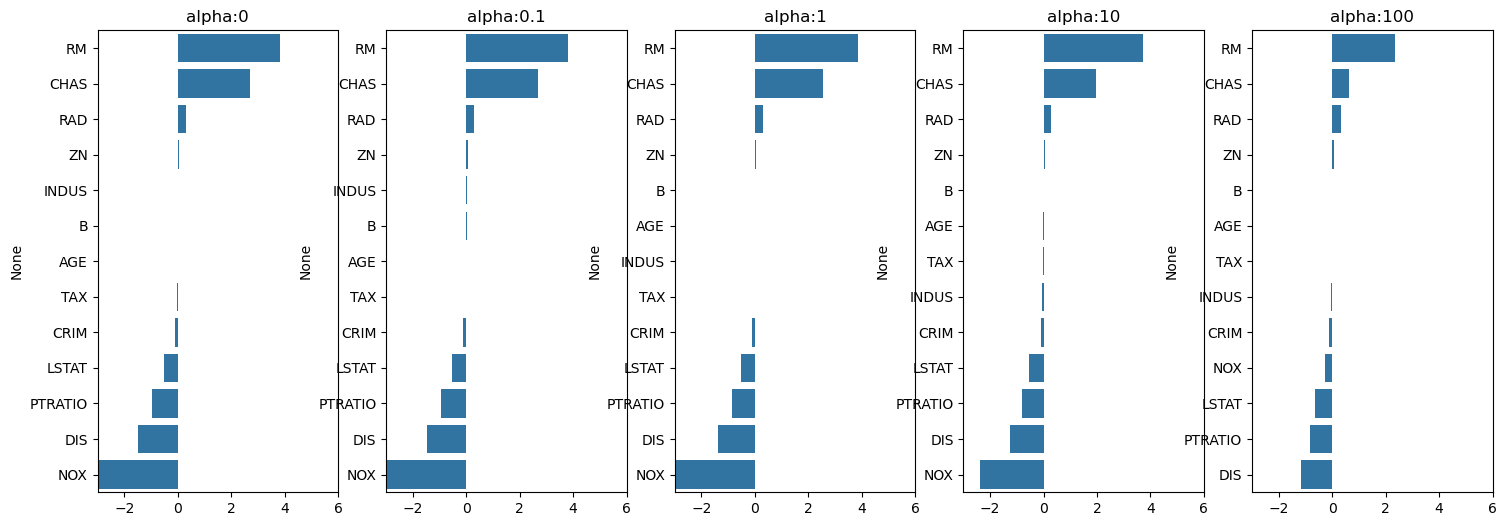

In [9]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장, pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화, 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 게수를 DataFrame으로 표시
plt.show()

In [10]:
ridge_alphas= [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


alpha 값이 증가하면서 회귀 계수가 지속적으로 작아지고 있음. 하지만 릿지 회귀의 경우 회귀 계수를 0으로 만들지는 않음.

### 라쏘 회귀
- 라쏘 회귀 비용함수의 목표는 RSS(W)+ alpha*||W|| 식을 최소화하는 W를 찾는 것
- L1 규제는 불필요한 회귀 계쑤를 급격하게 감소시켜 0으로 만들고 제거
- 사이킷런은 Lasso 클래스 통해 라쏘 회귀를 구현
- Lasso 클래스의 주요 생성 파라미터는 alpha이며, 이는 라쏘 회귀의 alpha L1 규제 계수에 해당

In [13]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n = None, y_target_n = None, verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print("######" , model_name, "######")
    for param in params:
        if model_name == 'Ridge' : model = Ridge(alpha=param)
        elif model_name == 'Lasso' : model = Lasso(alpha=param)
        elif model_name ==  'ElasticNet' : model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE : {1:.3f}'.format(param, avg_rmse))
        # cross_val_score는 evaluaion metric만 반환하므로 모델을 다시 학습하여 회귀 계수를 추출
        model.fit(X_data_n, y_target_n)
        if return_coeff:
            # alpha에 따른 치러별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
            coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
            colname='alpha:'+str(param)
            coeff_df[colname] = coeff

    return coeff_df

# end of get_linear_regre_eval

In [14]:
# 라쏘에 사용될 alpha 파라미터 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

###### Lasso ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE : 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE : 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE : 6.189


In [15]:
# 반환된 coeff_lasso_df를 첫 번쨰 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


### 엘라스틱넷 회귀
- L2 규제와 L1 규제를 결합한 회귀
- 엘라스틱넷 회귀 비용함수의 목표는 RSS(W) + alpha2*||W|| + alpha*||W|| 식을 최소화하는 W를 찾는 것
- 장점 : 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우 이들 중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강한데, 엘라스틱넷 회귀는 이를 완화하기 위해 L2 규제를 라쏘 회귀에 추가한 것
- 단점 : L1과 L2 규제가 결합된 규제로 인해 수행시간이 상대적으로 오래 걸림
- 사이킷런은 ElasticNet 클래스를 통해 엘라스틱넷 회귀를 구현

In [17]:
# 엘라스틱넷에 사용될 alpha 파라미터 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n = X_data, y_target_n = y_target)

###### ElasticNet ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE : 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE : 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE : 6.068


In [18]:
# 반환된 coeff_elastic_df를 첫 번쨰 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


### 선형 회귀 모델을 위한 데이터 변환

1. StandardScaler 클래스 이용해 평균 0, 분산 1인 표준 정규 분포 가진 데이터 세트로 변환하거나 MinMaxScaler 클래스 이용해 최솟값 0, 최댓값 1인 값으로 정규화 수행
2. 스케일링/정규화 수행한 데이터 세트에 다시 다항 특성을 적용해 변환하는 방법. 보통 1번 방법을 통해 예측 성능에 향상 없을 경우 이와 같은 방법을 적용
3. 원래 값에 log 함수 적용하면 보다 정규 분포에 가까운 형태로 값이 분포됨. 이러한 변환을 로그 변환(Log Transformation)이라고 부름. 로그 변환은 매우 유용한 변환이며, 실제로 선형 회귀에서는 앞에서 소개한 1,2 번 방법보다 로그 변환이 훨씬 많이 사용되는 변환 방법임.

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용. p_degree는 2 이상 부여 안함
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else : 
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

    return scaled_data

In [22]:
# Ridge의 alpha 값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변한. 먼저 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변한
scale_methods=[(None, None), ('Standard', None), ('Standard', 2),
               ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False, return_coeff=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE : 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE : 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 8.827
alpha 1일 때 5 폴드 세트의 평균 RMSE : 6.871
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.485
alpha 100일 때 5 폴드 세트의 평균 RMSE : 4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.764
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.465
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.754
alpha 100일 때 5 폴드 세트의 평균 RMSE : 7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.298
alpha 1일 때 5 폴드 세트의 평균 RMSE : 4.323
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.185
alpha 100일 때 5 폴드 세트의 평균 RMSE : 6.538

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴

# 07 로지스틱 회귀

- 선형 회귀 방식을 분류에 적용한 알고리즘
- 시그모이드 함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정한다는 것

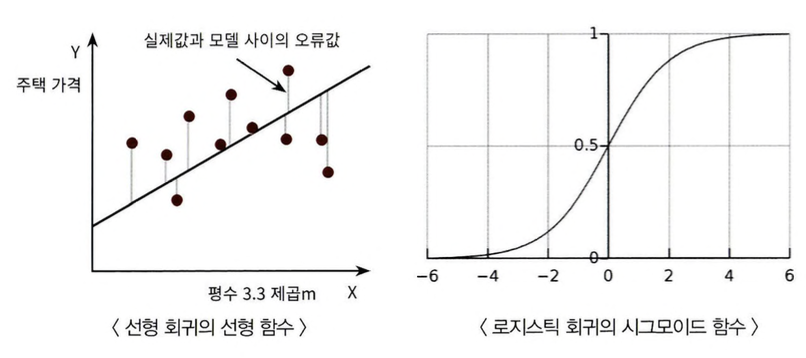

- 사이킷런은 로지스틱 회귀 위해 LogisticRegression 클래스 제공

- lbfgs : 사이킷런 버전 0.22부터 solver의 기본 설정값. 메모리 공간을 절약할 수 있고, CPU 코어 수가 많다면 최적화를 병렬로 수행 가능
- liblinear : 사이킷런 버전 0.21까지에서 solver의 기본 설정값. 다차원이고 작은 데이터 세트에서 효과적으로 동작하지만 국소 최적화(Local Minimum)에 이슈가 있고, 병렬로 최적화할 수 없음
- newton-cg : 좀 더 정교한 최적화를 가능하게 하지만, 대용량 데이터에서 속도가 많이 느려짐
- sag : Stochastic Average Gradient로서 경사 하강법 기반의 최적화르 적용. 대용향의 데이터에서 빠르게 최적화 함
- saga : sag와 유사한 최적화 방식이며 L1 정규화를 가능하게 해줌

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀 이용해 학습 및 예측 수행
# solver 인자값을 생성자로 입력하지 않으면 solver='lbfgs'
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:,1]

# accuracy와 roc_auc 측정
print('accuracy: {0:.3f}, roc_auc:{1:.3f}'.format(accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds_proba)))

accuracy: 0.977, roc_auc:0.995


In [28]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

# 여러 개의 solver 값별로 LogisticRegression 학습 후 성능 평가
for solver in solvers:
    lr_clf = LogisticRegression(solver=solver, max_iter=600)
    lr_clf.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_test)
    lr_preds_proba = lr_clf.predict_proba(X_test)[:,1]

    # accuracy와 roc_auc 측정
    print('solver:{0}, accuracy: {1:.3f}, roc_auc:{2:.3f}'.format(solver, accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds_proba)))

solver:lbfgs, accuracy: 0.977, roc_auc:0.995
solver:liblinear, accuracy: 0.982, roc_auc:0.995
solver:newton-cg, accuracy: 0.977, roc_auc:0.995
solver:sag, accuracy: 0.982, roc_auc:0.995
solver:saga, accuracy: 0.982, roc_auc:0.995


In [29]:
from sklearn.model_selection import GridSearchCV

params = {'solver':['liblinear', 'lbfgs'],
        'penalty':['l2', 'l1'],
        'C':[0.01, 0.1, 1, 5, 10]}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.979


# 08 회귀 트리

- 트리 기반의 회귀는 회귀 트리를 이용하는 것
- 결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등 앞 4장 분류에서 소개한 모든 트리 기반의 알고리즘은 분류뿐만 아니라 회귀도 가능
- 사이킷런에서 CART 기반의 회귀 수행을 할 수 있는 Estimator 클래스를 제공

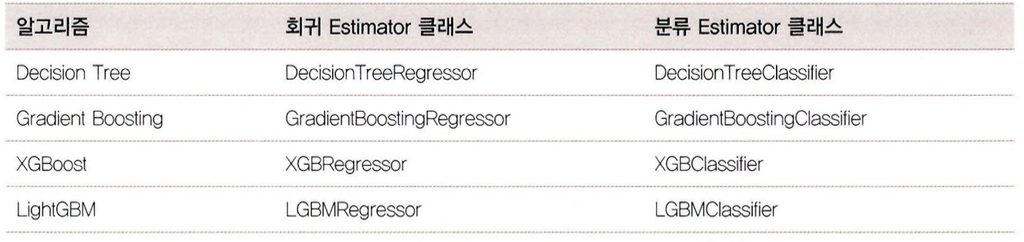

In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#보스턴 데이터 세트 로드
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
bostonDF = pd.DataFrame(data, columns=['CRIM','ZN','INDUS','CHAS', 'NOX','RM','AGE','DIS',
                                       'RAD','TAX','PTRATIO','B','LSTAT'])

bostonDF['PRICE']=target
y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis=1, inplace=False)

rf=RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores=cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores:', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores:', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE:{0:.3f}'.format(avg_rmse))

5 교차 검증의 개별 Negative MSE scores: [ -7.9  -13.03 -20.59 -46.21 -18.84]
5 교차 검증의 개별 RMSE scores: [2.81 3.61 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE:4.419


In [66]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    rmse_socres = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('#####', model.__class__.__name__, '#####')
    print('5 교차 검증의 평균 RMSE: {0:.3f}'.format(avg_rmse))

In [70]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=100)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=100)
xgb_reg = XGBRegressor(n_estimatros=100)
lgb_reg = LGBMRegressor(n_estimators=100)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

##### DecisionTreeRegressor #####
5 교차 검증의 평균 RMSE: 4.419
##### RandomForestRegressor #####
5 교차 검증의 평균 RMSE: 4.419
##### GradientBoostingRegressor #####
5 교차 검증의 평균 RMSE: 4.419
[13:40:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimatros" } are not used.

[13:40:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimatros" } are not used.

[13:40:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimatros" } are not used.

[13:40:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimatros" } are not used.

[13:40:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.m

<Axes: xlabel='None', ylabel='None'>

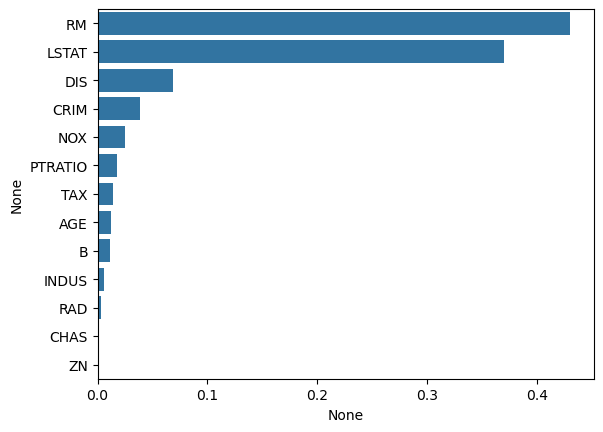

In [76]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=100)

# 앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용해 학습함
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

(100, 2)


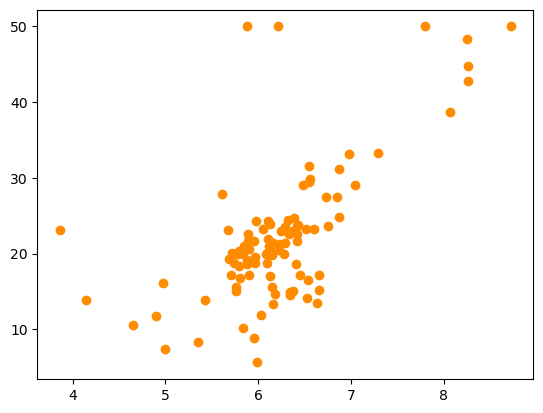

In [80]:
bostonDF_sample = bostonDF[['RM', 'PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')

In [84]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5 ~ 8.5까지의 100개 데이터 세트로 생성.
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

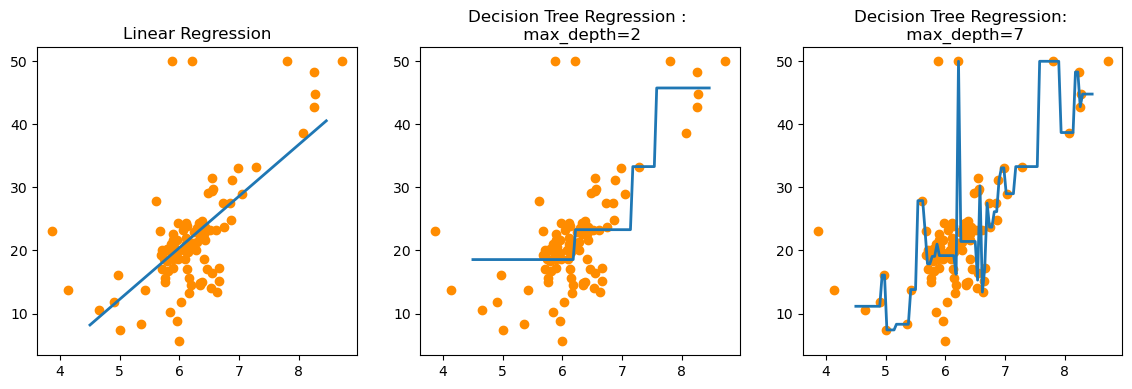

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X 축 값을 4.5~8.5로 변환하며 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('Decision Tree Regression : \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax2.plot(X_test, pred_rf2, label='max_depth:3', linewidth=2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax3.plot(X_test, pred_rf7, label='max_depth:7', linewidth=2)